In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# model
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 48, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
        )
        self.middle = nn.Sequential(
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
        )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(48, 1, kernel_size=3, padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x

# data load
class NoisyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        # Walk through ROIs
        for roi_name in os.listdir(root_dir):
            roi_path = os.path.join(root_dir, roi_name)
            if not os.path.isdir(roi_path):
                continue
            for subfolder in os.listdir(roi_path):
                subfolder_path = os.path.join(roi_path, subfolder)
                if not os.path.isdir(subfolder_path):
                    continue
                pmt1_path = os.path.join(subfolder_path, 'PMT1.tiff')
                pmt2_path = os.path.join(subfolder_path, 'PMT2.tiff')
                if os.path.isfile(pmt1_path) and os.path.isfile(pmt2_path):
                    self.samples.append((pmt1_path, pmt2_path))

        # Define resize transform to 384x384
        self.resize_transform = transforms.Resize((384, 384))

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        pmt1_path, pmt2_path = self.samples[idx]
        
        # Open as PIL Image first (to use torchvision resize)
        pmt1 = Image.open(pmt1_path).convert('F')  # 'F' mode = 32-bit float grayscale
        pmt2 = Image.open(pmt2_path).convert('F')

        # Resize to (384, 384)
        pmt1 = self.resize_transform(pmt1)
        pmt2 = self.resize_transform(pmt2)

        # Convert to numpy arrays and normalize to [0,1]
        pmt1 = np.array(pmt1).astype(np.float32) / 255.0
        pmt2 = np.array(pmt2).astype(np.float32) / 255.0

        # Convert to tensors
        pmt1 = torch.from_numpy(pmt1).unsqueeze(0)  # (1, 384, 384)
        pmt2 = torch.from_numpy(pmt2).unsqueeze(0)

        return pmt1, pmt2




# Train
def train_model(model, dataloader, device, num_epochs=50):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}")

    print('Training complete.')
    return model

# Train
if __name__ == "__main__":
    root_dir = '/Users/alliyaparvez/Documents/canc_img_denois_s25/dataset/depeppered_endoscopic_scans'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    dataset = NoisyDataset(root_dir=root_dir)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

    model = SimpleUNet()
    trained_model = train_model(model, dataloader, device, num_epochs=50)

    # Save model
    torch.save(trained_model.state_dict(), 'noisier2noise_model.pth')


Epoch [1/50], Loss: 0.000081
Epoch [2/50], Loss: 0.000005
Epoch [3/50], Loss: 0.000002
Epoch [4/50], Loss: 0.000002
Epoch [5/50], Loss: 0.000002
Epoch [6/50], Loss: 0.000002
Epoch [7/50], Loss: 0.000002
Epoch [8/50], Loss: 0.000001
Epoch [9/50], Loss: 0.000001
Epoch [10/50], Loss: 0.000001
Epoch [11/50], Loss: 0.000001
Epoch [12/50], Loss: 0.000001
Epoch [13/50], Loss: 0.000001
Epoch [14/50], Loss: 0.000001
Epoch [15/50], Loss: 0.000001
Epoch [16/50], Loss: 0.000001
Epoch [17/50], Loss: 0.000001
Epoch [18/50], Loss: 0.000001
Epoch [19/50], Loss: 0.000001
Epoch [20/50], Loss: 0.000001
Epoch [21/50], Loss: 0.000001
Epoch [22/50], Loss: 0.000002
Epoch [23/50], Loss: 0.000001
Epoch [24/50], Loss: 0.000001
Epoch [25/50], Loss: 0.000001
Epoch [26/50], Loss: 0.000001
Epoch [27/50], Loss: 0.000001
Epoch [28/50], Loss: 0.000001
Epoch [29/50], Loss: 0.000001
Epoch [30/50], Loss: 0.000001
Epoch [31/50], Loss: 0.000001
Epoch [32/50], Loss: 0.000001
Epoch [33/50], Loss: 0.000001
Epoch [34/50], Loss

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Laod model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleUNet()
model.load_state_dict(torch.load('noisier2noise_model.pth', map_location=device))
model = model.to(device)
model.eval()

folder_path = '/Users/alliyaparvez/Documents/canc_img_denois_s25/dataset/float32_endoscopic_scans/ROI_1/Image-20250326-231205-592'
pmt1_path = f'{folder_path}/PMT1.tiff'
pmt2_path = f'{folder_path}/PMT2.tiff'

# roi mask
h, w = noisy_img.shape
Y, X = np.ogrid[:h, :w]
center_x, center_y = w // 2, h // 2
radius = min(h, w) // 2
circular_mask = ((X - center_x)**2 + (Y - center_y)**2) <= radius**2

# denoise + display 
def denoise_and_display(image_path, title_prefix='PMT'):
    # Load image
    img = Image.open(image_path).convert('F')
    img = img.resize((384, 384))  # Resize to 384x384 if needed
    img_np = np.array(img).astype(np.float32) / 255.0

    # Prepare input
    input_tensor = torch.from_numpy(img_np).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        output_tensor = model(input_tensor)

    
    # Convert back to numpy
    original = input_tensor.squeeze().cpu().numpy()
    denoised = output_tensor.squeeze().cpu().numpy()
   
    denoised = hist_eq_img * circular_mask.astype(np.float32)
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title(f'{title_prefix} Original')
    axes[0].axis('off')

    axes[1].imshow(denoised, cmap='gray')
    axes[1].set_title(f'{title_prefix} Denoised')
    axes[1].axis('off')

    plt.show()

# display
denoise_and_display(pmt1_path, title_prefix='PMT1')
denoise_and_display(pmt2_path, title_prefix='PMT2')


FileNotFoundError: [Errno 2] No such file or directory: 'noisier2noise_model.pth'

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

# model
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 48, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
        )
        self.middle = nn.Sequential(
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
        )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(48, 1, kernel_size=3, padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x

# dataset load
class SingleChannelDataset(Dataset):
    def __init__(self, root_dir, channel='PMT1'):
        self.samples = []
        self.channel = channel

        for roi_name in os.listdir(root_dir):
            roi_path = os.path.join(root_dir, roi_name)
            if not os.path.isdir(roi_path):
                continue
            for subfolder in os.listdir(roi_path):
                subfolder_path = os.path.join(roi_path, subfolder)
                if not os.path.isdir(subfolder_path):
                    continue
                pmt_path = os.path.join(subfolder_path, f'{channel}.tiff')
                if os.path.isfile(pmt_path):
                    self.samples.append(pmt_path)

        self.resize_transform = transforms.Resize((384, 384))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path = self.samples[idx]
        img = Image.open(img_path).convert('F')  # 'F' mode 32-bit grayscale
        img = self.resize_transform(img)
        img = np.array(img).astype(np.float32) / 255.0
        img = torch.from_numpy(img).unsqueeze(0)  # (1, 384, 384)

        # Here, noisy input and target are the same (self-supervised)
        return img, img

# train
def train_model(model, dataloader, device, num_epochs=50):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}")

    print('Training complete.')
    return model

# train sepearet mdoels
if __name__ == "__main__":
    root_dir = '/Users/alliyaparvez/Documents/canc_img_denois_s25/dataset/wdppns_endoscopic_scans'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # pmt1
    print("Training model for PMT1...")
    dataset_pmt1 = SingleChannelDataset(root_dir=root_dir, channel='PMT1')
    dataloader_pmt1 = DataLoader(dataset_pmt1, batch_size=4, shuffle=True)

    model_pmt1 = SimpleUNet()
    trained_model_pmt1 = train_model(model_pmt1, dataloader_pmt1, device, num_epochs=150)

    torch.save(trained_model_pmt1.state_dict(), 'noisier2noise_model_pmt1.pth')

    # pmt2
    print("\nTraining model for PMT2...")
    dataset_pmt2 = SingleChannelDataset(root_dir=root_dir, channel='PMT2')
    dataloader_pmt2 = DataLoader(dataset_pmt2, batch_size=4, shuffle=True)

    model_pmt2 = SimpleUNet()
    trained_model_pmt2 = train_model(model_pmt2, dataloader_pmt2, device, num_epochs=50)

    torch.save(trained_model_pmt2.state_dict(), 'noisier2noise_model_pmt2.pth')


Training model for PMT1...
Epoch [1/150], Loss: 7391.476583
Epoch [2/150], Loss: 778.288182
Epoch [3/150], Loss: 432.334953
Epoch [4/150], Loss: 291.236508
Epoch [5/150], Loss: 243.164943
Epoch [6/150], Loss: 216.774831
Epoch [7/150], Loss: 198.651374
Epoch [8/150], Loss: 178.041390
Epoch [9/150], Loss: 157.135256
Epoch [10/150], Loss: 130.514347
Epoch [11/150], Loss: 109.039775
Epoch [12/150], Loss: 96.957430
Epoch [13/150], Loss: 85.895353
Epoch [14/150], Loss: 75.898234
Epoch [15/150], Loss: 67.245024
Epoch [16/150], Loss: 59.519456
Epoch [17/150], Loss: 53.797883
Epoch [18/150], Loss: 50.002808
Epoch [19/150], Loss: 43.642168
Epoch [20/150], Loss: 37.050657
Epoch [21/150], Loss: 31.894210
Epoch [22/150], Loss: 25.002609
Epoch [23/150], Loss: 33.092670
Epoch [24/150], Loss: 29.474303
Epoch [25/150], Loss: 23.309880
Epoch [26/150], Loss: 19.670402
Epoch [27/150], Loss: 16.022606
Epoch [28/150], Loss: 15.082070
Epoch [29/150], Loss: 13.908072
Epoch [30/150], Loss: 13.719578
Epoch [31/

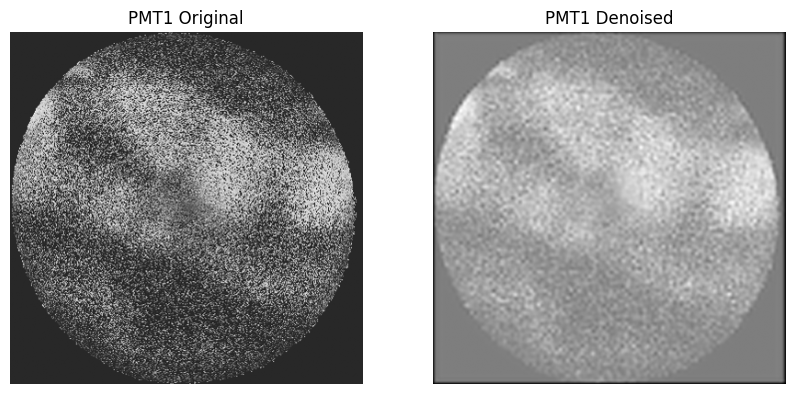

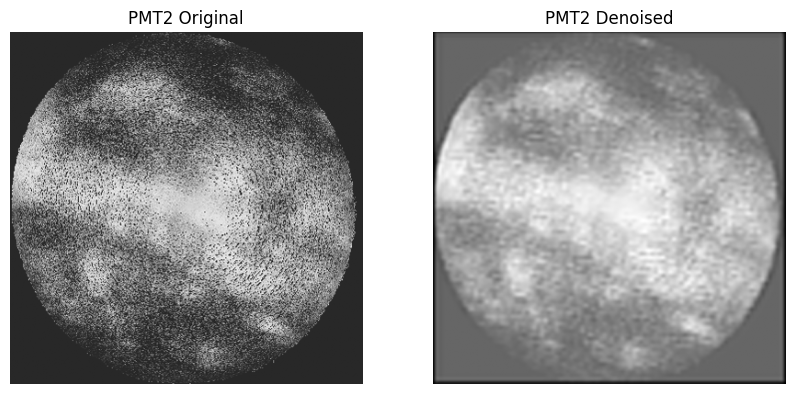

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_pmt1 = SimpleUNet()
model_pmt1.load_state_dict(torch.load('noisier2noise_model_pmt1.pth', map_location=device))
model_pmt1 = model_pmt1.to(device)
model_pmt1.eval()

model_pmt2 = SimpleUNet()
model_pmt2.load_state_dict(torch.load('noisier2noise_model_pmt2.pth', map_location=device))
model_pmt2 = model_pmt2.to(device)
model_pmt2.eval()

folder_path = '/Users/alliyaparvez/Documents/canc_img_denois_s25/dataset/float32_endoscopic_scans/ROI_1/Image-20250326-231205-592'
pmt1_path = f'{folder_path}/PMT1.tiff'
pmt2_path = f'{folder_path}/PMT2.tiff'


def denoise_and_display(image_path, model, title_prefix='PMT'):
    # Load image
    img = Image.open(image_path).convert('F')
    img = img.resize((384, 384))  # Resize to 384x384 if needed
    img_np = np.array(img).astype(np.float32) / 255.0

    # Prepare input
    input_tensor = torch.from_numpy(img_np).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        output_tensor = model(input_tensor)

    # Convert back to numpy
    original = input_tensor.squeeze().cpu().numpy()
    denoised = output_tensor.squeeze().cpu().numpy()

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title(f'{title_prefix} Original')
    axes[0].axis('off')

    axes[1].imshow(denoised, cmap='gray')
    axes[1].set_title(f'{title_prefix} Denoised')
    axes[1].axis('off')

    plt.show()

    return denoised


denoised_pmt1 = denoise_and_display(pmt1_path, model_pmt1, title_prefix='PMT1')
denoised_pmt2 = denoise_and_display(pmt2_path, model_pmt2, title_prefix='PMT2')

# Save denoised images as float32 TIFF
Image.fromarray(denoised_pmt1.astype(np.float32)).save('denoised_pmt1.tiff', format='TIFF')
Image.fromarray(denoised_pmt2.astype(np.float32)).save('denoised_pmt2.tiff', format='TIFF')


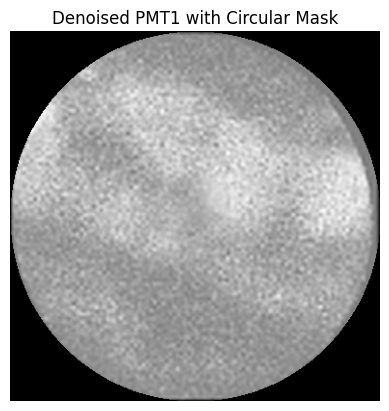

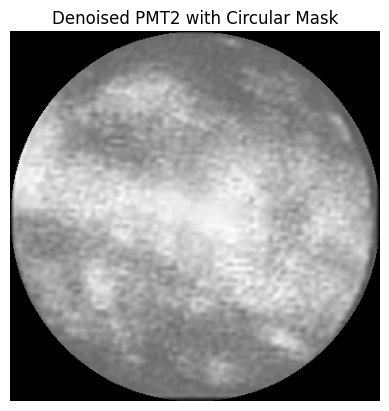

In [ ]:

h, w = circular_mask.shape  # Use the existing circular_mask dimensions

# show 'denoised_pmt1.tiff'
denoised_pmt1 = np.array(Image.open('denoised_pmt1.tiff')).astype(np.float32)
# =============== Step 5: Apply Circular Mask ===============
denoised_pmt1 = denoised_pmt1 * circular_mask.astype(np.float32)
plt.imshow(denoised_pmt1, cmap='gray')
plt.title('Denoised PMT1 with Circular Mask')
plt.axis('off')
plt.show()

# show 'denoised_pmt2.tiff'
denoised_pmt2 = np.array(Image.open('denoised_pmt2.tiff')).astype(np.float32)

denoised_pmt2 = denoised_pmt2 * circular_mask.astype(np.float32)
plt.imshow(denoised_pmt2, cmap='gray')
plt.title('Denoised PMT2 with Circular Mask')
plt.axis('off')
plt.show()


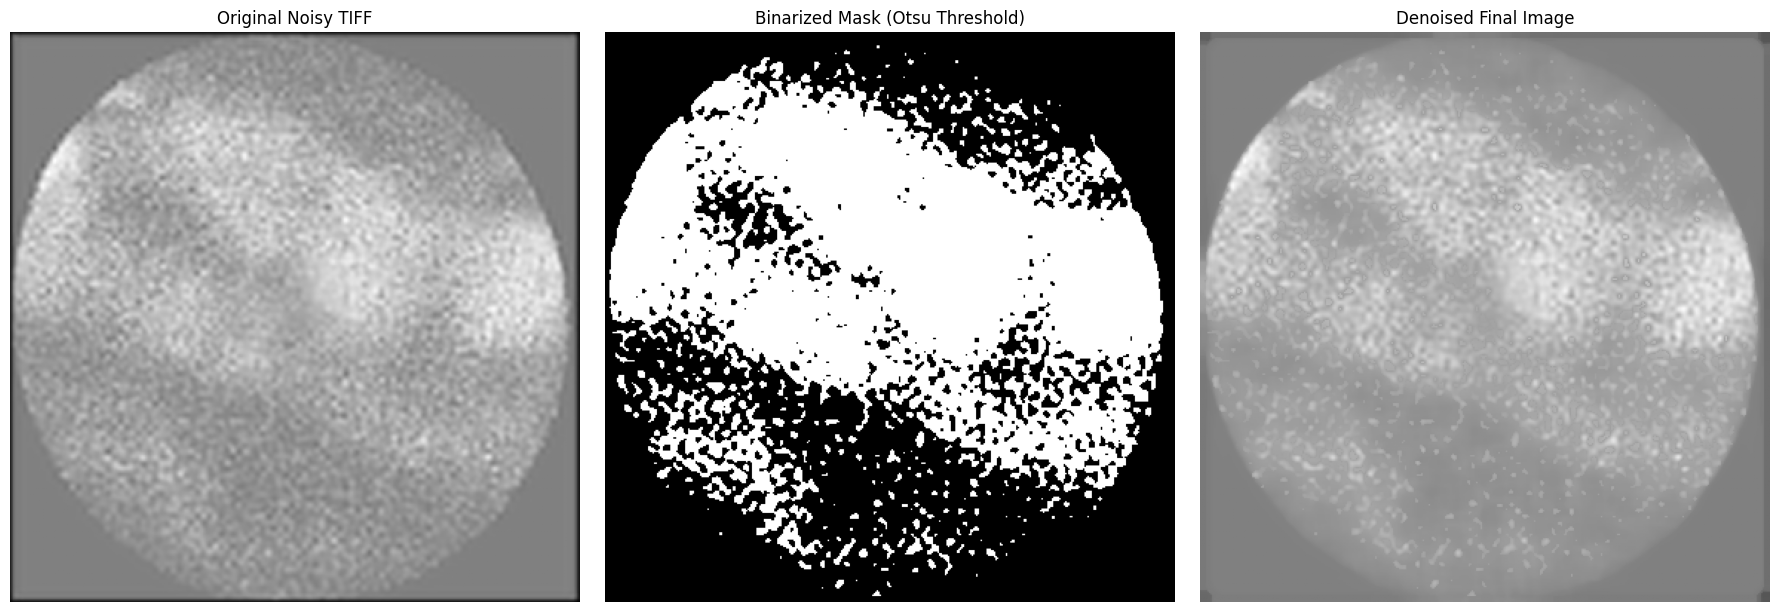

In [29]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from scipy.ndimage import median_filter

# Load the noisy scan (TIFF, float32)
noisy_img = cv2.imread('denoised_pmt1.tiff', cv2.IMREAD_UNCHANGED).astype(np.float32)

# Normalize to [0,1] if needed (optional if your TIFF isn't already scaled)
if noisy_img.max() > 1.0:
    noisy_img = noisy_img / np.max(noisy_img)

# Step 1: Binarize using Otsu threshold
thresh_val = threshold_otsu(noisy_img)
binary_img = (noisy_img > thresh_val).astype(np.float32)

# Step 2: Smooth the noisy scan
smoothed_img = median_filter(noisy_img, size=15)  # 3x3 median filter

# Step 3: Blend: keep strong signal from binarized regions, smooth background
final_img = np.where(binary_img == 1, noisy_img, smoothed_img)

# Step 4: Display all results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(noisy_img, cmap='gray', vmin=0, vmax=1)
axes[0].set_title('Original Noisy TIFF')
axes[0].axis('off')

axes[1].imshow(binary_img, cmap='gray')
axes[1].set_title('Binarized Mask (Otsu Threshold)')
axes[1].axis('off')

axes[2].imshow(final_img, cmap='gray', vmin=0, vmax=1)
axes[2].set_title('Denoised Final Image')
axes[2].axis('off')

plt.tight_layout()
plt.show()


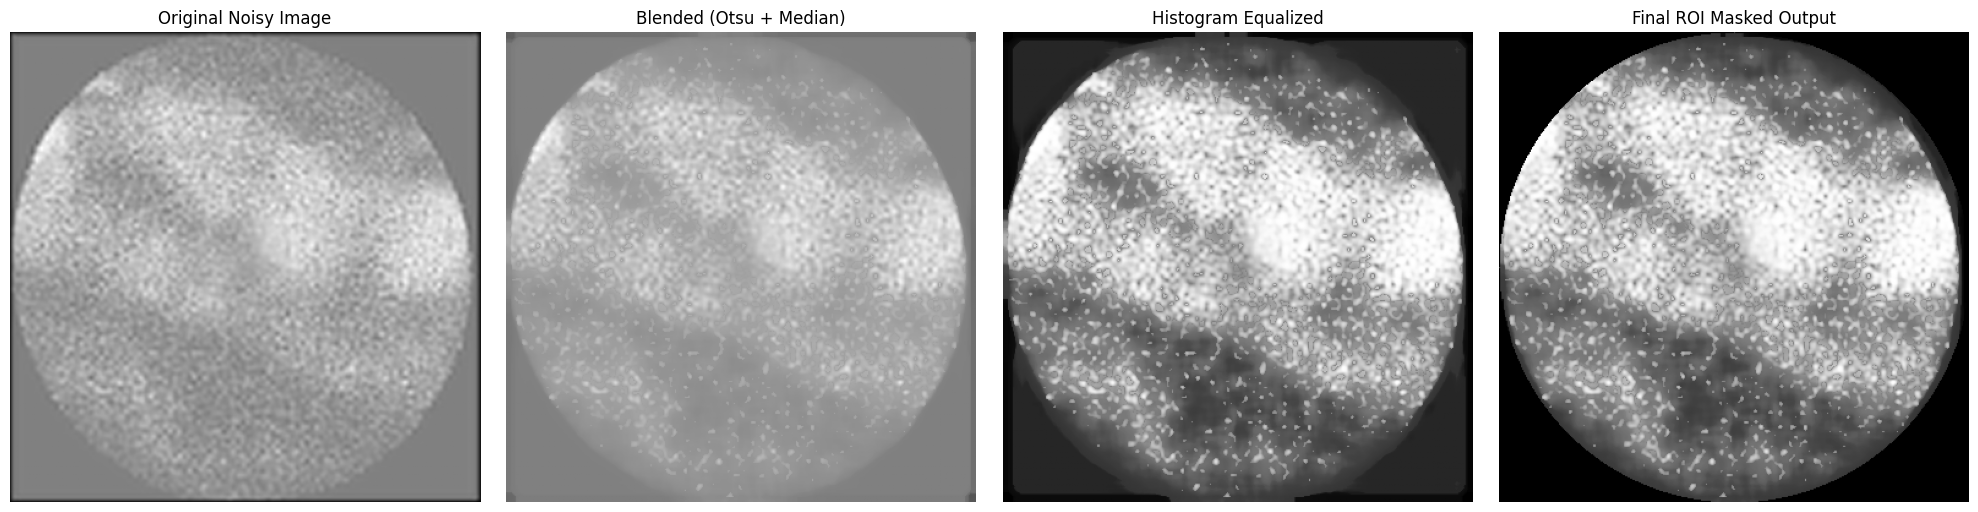

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from scipy.ndimage import median_filter
from skimage import exposure

noisy_img = cv2.imread('denoised_pmt1.tiff', cv2.IMREAD_UNCHANGED).astype(np.float32)

# Normalize to [0,1] if needed
if noisy_img.max() > 1.0:
    noisy_img = noisy_img / np.max(noisy_img)


h, w = noisy_img.shape
Y, X = np.ogrid[:h, :w]
center_x, center_y = w // 2, h // 2
radius = min(h, w) // 2
circular_mask = ((X - center_x)**2 + (Y - center_y)**2) <= radius**2

# otsu threshold
thresh_val = threshold_otsu(noisy_img)
binary_img = (noisy_img > thresh_val).astype(np.float32)

# median filter
smoothed_img = median_filter(noisy_img, size=15)

# blend signal 
blended_img = np.where(binary_img == 1, noisy_img, smoothed_img)

# histogram equalisation 
hist_eq_img = exposure.equalize_hist(blended_img)


final_img = hist_eq_img * circular_mask.astype(np.float32)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(noisy_img, cmap='gray', vmin=0, vmax=1)
axes[0].set_title('Original Noisy Image')
axes[0].axis('off')

axes[1].imshow(blended_img, cmap='gray', vmin=0, vmax=1)
axes[1].set_title('Blended (Otsu + Median)'
axes[1].axis('off')

axes[2].imshow(hist_eq_img, cmap='gray', vmin=0, vmax=1)
axes[2].set_title('Histogram Equalized')
axes[2].axis('off')

axes[3].imshow(final_img, cmap='gray', vmin=0, vmax=1)
axes[3].set_title('Final ROI Masked Output')
axes[3].axis('off')

plt.tight_layout()
plt.show()


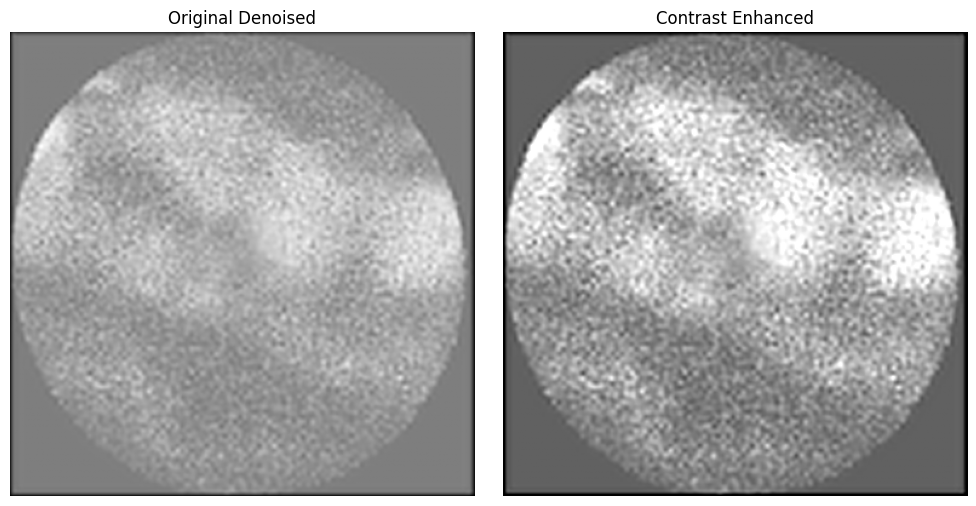

FileNotFoundError: [Errno 2] No such file or directory: '/path/to/save/contrast_enhanced_image.tiff'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


denoised_path = 'denoised_pmt1.tiff'
img = np.array(Image.open(denoised_path)).astype(np.float32)

# Normalize if needed
img = img / 65535.0 if img.max() > 1.0 else img

# comntrast stretching
def simple_contrast_enhance(image, low_percentile=2, high_percentile=98):
    p_low, p_high = np.percentile(image, (low_percentile, high_percentile))
    image_stretched = np.clip((image - p_low) / (p_high - p_low), 0, 1)
    return image_stretched

img_contrast = simple_contrast_enhance(img)

# display
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Denoised')
axes[0].axis('off')

axes[1].imshow(img_contrast, cmap='gray')
axes[1].set_title('Contrast Enhanced')
axes[1].axis('off')

plt.tight_layout()
plt.show()

Image.fromarray((img_contrast * 65535).astype(np.uint16)).save('/path/to/save/contrast_enhanced_image.tiff')


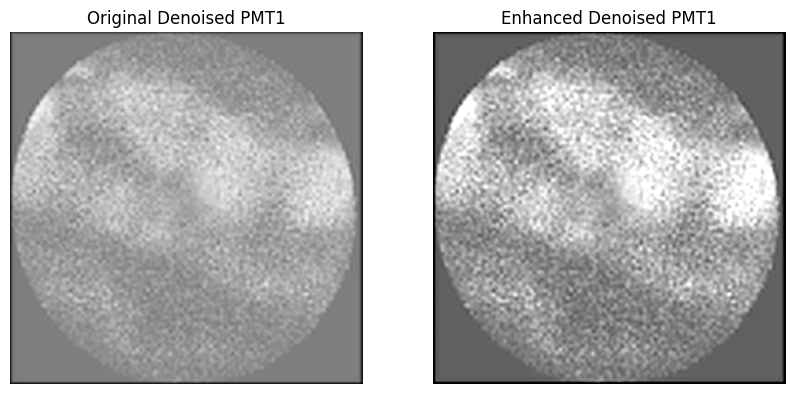

In [ ]:
import numpy as np
from PIL import Image

image_path = 'denoised_pmt1.tiff'

img = np.array(Image.open(image_path)).astype(np.float32)

# Normalize if needed
img = img / 65535.0 if img.max() > 1.0 else img

p2, p98 = np.percentile(img, (2, 98))  # Stretch between 2nd and 98th percentiles
img_contrast = np.clip((img - p2) / (p98 - p2), 0, 1)


img_contrast_uint16 = (img_contrast * 65535.0).astype(np.uint16)
Image.fromarray(img_contrast_uint16).save('enhanced_denoised_pmt1.tiff')

import matplotlib.pyplot as plt
# Display original and enhanced images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Denoised PMT1')
axes[0].axis('off')
axes[1].imshow(img_contrast, cmap='gray')
axes[1].set_title('Enhanced Denoised PMT1')
axes[1].axis('off')
plt.show()


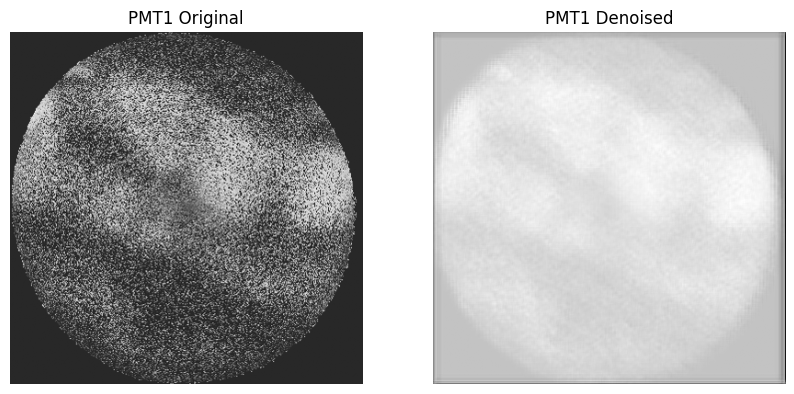

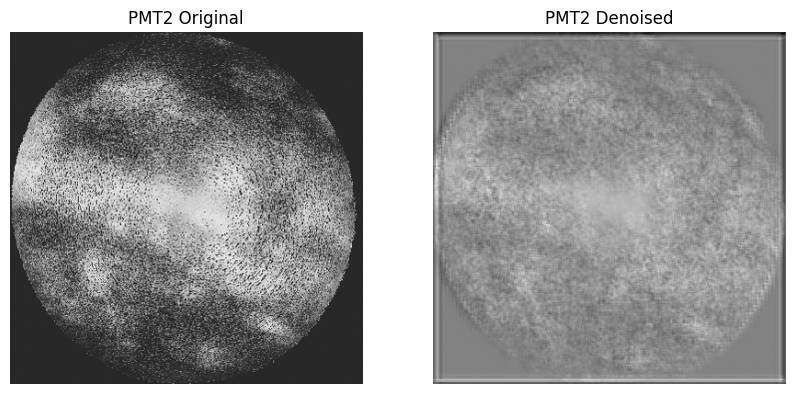

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_pmt1 = SimpleUNet()
model_pmt1.load_state_dict(torch.load('noisier2noise_model_pmt1.pth', map_location=device))
model_pmt1 = model_pmt1.to(device)
model_pmt1.eval()

model_pmt2 = SimpleUNet()
model_pmt2.load_state_dict(torch.load('noisier2noise_model_pmt2.pth', map_location=device))
model_pmt2 = model_pmt2.to(device)
model_pmt2.eval()


folder_path = '/Users/alliyaparvez/Documents/canc_img_denois_s25/dataset/float32_endoscopic_scans/ROI_1/Image-20250326-231205-592'
pmt1_path = f'{folder_path}/PMT1.tiff'
pmt2_path = f'{folder_path}/PMT2.tiff'


def denoise_and_display(image_path, model, title_prefix='PMT'):
    # Load image
    img = Image.open(image_path).convert('F')
    img = img.resize((384, 384))  # Resize to 384x384 if needed
    img_np = np.array(img).astype(np.float32) / 255.0

    # Prepare input
    input_tensor = torch.from_numpy(img_np).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        output_tensor = model(input_tensor)

    # Convert back to numpy
    original = input_tensor.squeeze().cpu().numpy()
    denoised = output_tensor.squeeze().cpu().numpy()

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title(f'{title_prefix} Original')
    axes[0].axis('off')

    axes[1].imshow(denoised, cmap='gray')
    axes[1].set_title(f'{title_prefix} Denoised')
    axes[1].axis('off')

    plt.show()

denoise_and_display(pmt1_path, model_pmt1, title_prefix='PMT1')
denoise_and_display(pmt2_path, model_pmt2, title_prefix='PMT2')


In [ ]:
# Noisier2Noise is a self-supervised learning method for denoising images. It uses pairs of noisy images to train a model to predict the clean image. The model learns to minimize the difference between the predicted and actual noisy images, effectively learning to denoise without needing clean ground truth images.

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image


class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 48, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
        )
        self.middle = nn.Sequential(
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
        )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(48, 1, kernel_size=3, padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x


class PairedNoisyDataset(Dataset):
    def __init__(self, root_dir, channel='PMT1'):
        self.channel = channel
        self.samples = []

        for roi_name in os.listdir(root_dir):
            roi_path = os.path.join(root_dir, roi_name)
            if not os.path.isdir(roi_path):
                continue

            timepoint_paths = []
            for timepoint in sorted(os.listdir(roi_path)):
                timepoint_path = os.path.join(roi_path, timepoint)
                if not os.path.isdir(timepoint_path):
                    continue
                pmt_path = os.path.join(timepoint_path, f'{channel}.tiff')
                if os.path.isfile(pmt_path):
                    timepoint_paths.append(pmt_path)

            if len(timepoint_paths) >= 2:
                self.samples.append(timepoint_paths)

        self.resize_transform = transforms.Resize((384, 384))

    def __len__(self):
        return len(self.samples) * 5  # To augment total number of training pairs

    def __getitem__(self, idx):
        roi_idx = idx % len(self.samples)
        timepoint_paths = self.samples[roi_idx]

        i, j = np.random.choice(len(timepoint_paths), size=2, replace=False)
        img1 = Image.open(timepoint_paths[i]).convert('F')
        img2 = Image.open(timepoint_paths[j]).convert('F')

        img1 = self.resize_transform(img1)
        img2 = self.resize_transform(img2)

        img1 = np.array(img1).astype(np.float32) / 255.0
        img2 = np.array(img2).astype(np.float32) / 255.0

        img1 = torch.from_numpy(img1).unsqueeze(0)
        img2 = torch.from_numpy(img2).unsqueeze(0)

        return img1, img2

# rmse loss trainer
def train_model(model, dataloader, device, num_epochs=50):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    def rmse_loss(pred, target):
        return torch.sqrt(torch.mean((pred - target) ** 2))

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = rmse_loss(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], RMSE Loss: {epoch_loss:.6f}")

    print('Training complete.')
    return model


if __name__ == "__main__":
    root_dir = '/Users/alliyaparvez/Documents/canc_img_denois_s25/dataset/wdppns_endoscopic_scans'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # pmt1
    print("Training paired Noise2Noise model for PMT1...")
    dataset_pmt1 = PairedNoisyDataset(root_dir=root_dir, channel='PMT1')
    dataloader_pmt1 = DataLoader(dataset_pmt1, batch_size=4, shuffle=True)

    model_pmt1 = SimpleUNet()
    trained_model_pmt1 = train_model(model_pmt1, dataloader_pmt1, device, num_epochs=150)

    torch.save(trained_model_pmt1.state_dict(), 'noise2noise_paired_model_pmt1.pth')

    # pmt2
    print("\nTraining paired Noise2Noise model for PMT2...")
    dataset_pmt2 = PairedNoisyDataset(root_dir=root_dir, channel='PMT2')
    dataloader_pmt2 = DataLoader(dataset_pmt2, batch_size=4, shuffle=True)

    model_pmt2 = SimpleUNet()
    trained_model_pmt2 = train_model(model_pmt2, dataloader_pmt2, device, num_epochs=150)

    torch.save(trained_model_pmt2.state_dict(), 'noise2noise_paired_model_pmt2.pth')
